# Buffering per basin, multi-GEM
Plot drought buffering split out per basin. Compare increasing/decreasing buffering per basin and per glacier model.

20 Aug 2024 | EHU

Edits:
- 1 Nov 2024: Change plot style to match end-century change plot for manuscript.  Open triangles for decrease (not shades of red), x's for no change.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy import stats
import gSPEI as gSPEI

In [2]:
## Define the filepath -- updated data on the desktop for now
fpath = '/Users/lizz/Desktop/SPEI-scoats-20240819/'

## Settings in filenames -- slightly different model names and scenarios
gmodels = ['GloGEM', 'PyGEM', 'OGGM']
integration_times = np.arange(3, 28, 4) # all SPEI integration times used

modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']


scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
cases = ['NRunoff', 'WRunoff', 'diff'] # inclusion of glacier runoff

yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [3]:
## We want to confirm that the basins are the same order Sloan used

#Load in list from total Basin area data -- following Finn percent glaciation code
from scipy.io import loadmat
import pandas as pd
path_to_area = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/BasinArea.mat' ## uploaded by Sloan
BasinAreas = loadmat(path_to_area)
#Creating indices a dataframe would use
basin_areas = BasinAreas['BasinArea']
basin_names = BasinAreas['BasinNam']
basin_name_list = [name[1][0] for name in basin_names]

revised_names = {'ISSYK-KUL': 'YSYK-KOL', 'LAGARFLIOT': 'LAGARFLJOT'}.get ## revise to align Sloan's names with Finn's spelling
basin_name_list = [revised_names(n,n) for n in basin_name_list]

basin_names=basin_name_list ## just to make sure to get them all

In [4]:
itime = integration_times[0] # select timescale of integration. [0] is 3 months, used in manuscript.
scen = scenarios[1] # choose which SSP to load

## Create terrible nested dictionary until we overhaul the rest of the structure
SPEI_by_GEM = {g: {} for g in gmodels} ## outer organization by glacier model
for g in gmodels:
    SPEI_by_model = {m: {} for m in modelnames} # create dictionary indexed by model name
    for m in modelnames:
        norunoff_f_m = fpath+'NRunoff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        wrunoff_f_m = fpath+'WRunOff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        SPEI_by_model[m]['NRunoff'] = np.loadtxt(norunoff_f_m)
        SPEI_by_model[m]['WRunoff'] = np.loadtxt(wrunoff_f_m)
        SPEI_by_model[m]['diff'] = SPEI_by_model[m]['WRunoff'] - SPEI_by_model[m]['NRunoff']
    SPEI_by_GEM[g] = SPEI_by_model

In the original `SPEI-analysis.ipynb`, we use `gSPEI.sort_models_to_basins` to organize by basin.  Here we have a different subset of basins to analyze...so we're doin' it live.

In [5]:
import pandas as pd 

SPEI_basin_sorted_GEM_raw = {g: {} for g in gmodels}
for g in gmodels:
    SPEI_by_basin = {b: {} for b in basin_name_list} # create dictionary indexed by basin name
    for i, b in enumerate(basin_name_list):
        SPEI_by_basin[b] = {case: {} for case in cases}
        for case in cases:
            tempdict = {}
            for m in modelnames:
                tempdict[m] = SPEI_by_GEM[g][m][case][i] # pull data from SPEI_by_model dicts into this new dict
            SPEI_by_basin[b][case] = pd.DataFrame.from_dict(tempdict)
    SPEI_basin_sorted_GEM_raw[g] = SPEI_by_basin

SPEI_basin_sorted_GEM = {g: {b: {} for b in basin_names} for g in gmodels}
for g in gmodels:
    for b in basin_names:
        for c in cases:
            SPEI_basin_sorted_GEM[g][b][c] = SPEI_basin_sorted_GEM_raw[g][b][c].fillna(-3) # fill negative excursions that were stored as NaNs

## Glacial drought buffering over time

Now we summarize the number and severity of droughts counted in all basins, for all GCMs, for each GEM.  We contrast the SPEI$_N$ series versus SPEI$_W$ series to isolate glacial drought buffering on each metric.

We use another helper function to identify the droughts in each series and summarize them all, storing each in a dictionary per time period such that we can see change over time.

Here we will use the early century 2000-2020 as a reference period.  We set up another layer of dictionary to include the GEM differences.

In [6]:
basin_stats_bymodel_early = {g: 
                            {m: 
                             {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2000,2020)) for b in basin_names}
                             for m in modelnames}
                            for g in gmodels} 
basin_stats_bymodel_midC = {g: 
                            {m: 
                            {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2040,2060)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}
                            
basin_stats_bymodel_endC = {g:
                            {m: {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2080,2100)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}

/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:479: RuntimeWarning: Mean of empty slice
  mean_drtdur_w = np.nanmean([np.mean(drt_dur_w_bymodel[m]) for m in modelnames])
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:481: RuntimeWarning: Mean of empty slice
  mean_drtsev_w = np.nanmean([np.mean(drt_sev_w_bymodel[m]) for m in modelnames])


In [8]:
basin_stats_bymodel_early['GloGEM'][modelnames[0]]['INDUS']

[(14.0, 15.0),
 (6.785714285714286, 6.666666666666667),
 (-7.154211286214286, -7.5489181540666666)]

In [9]:
basin_stats_bymodel_midC['GloGEM'][modelnames[0]]['INDUS']

[(16.0, 18.0),
 (6.1875, 6.611111111111111),
 (-7.2350768066875, -7.493108738611111)]

In [10]:
basin_stats_bymodel_endC['GloGEM'][modelnames[0]]['INDUS']

[(21.0, 20.0),
 (5.761904761904762, 7.0),
 (-7.077195155809524, -8.141801516249998)]

These should agree with spot-check results from our other 2024 notebooks. Confirm they do before proceeding.

### Basin-by-basin comparison of the three GEMs
Let's make an example panel comparing the three GEMs buffering for the three time periods.

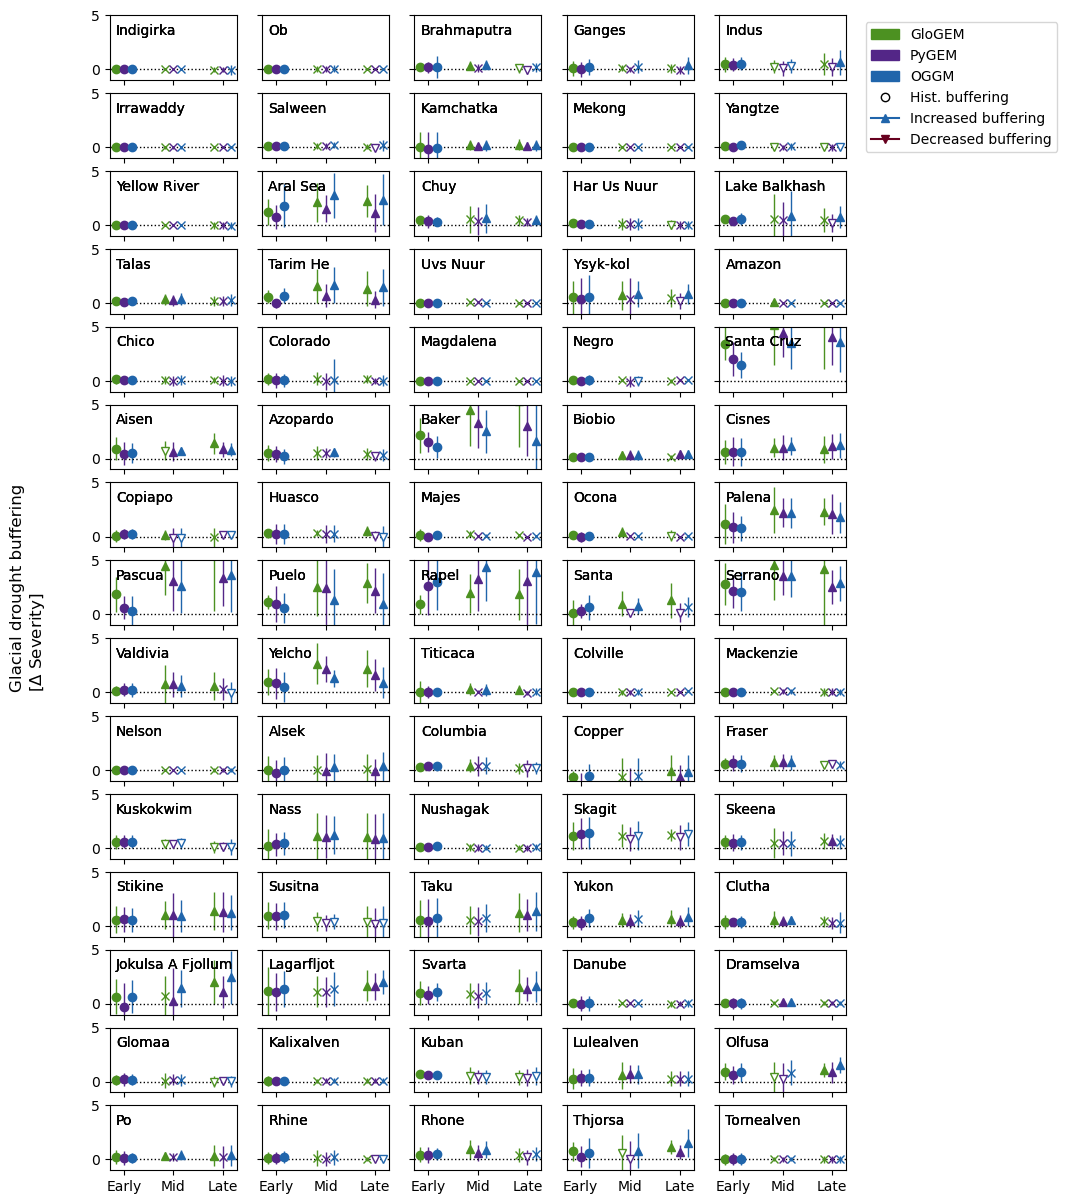

In [13]:
# colors = {'GloGEM': 'darkgreen',
#           'PyGEM': 'Purple',
#           'OGGM': 'royalblue'}
## these are what we used in Finn's MS
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


## Color defaults per model - diverging cmaps
colorcode = [ 'PiYG', 'PuOr', 'RdBu']
pos_spread = [-0.5, 0, 0.5]

fig,axs = plt.subplots(15,5, figsize=(9.5,15), sharex=True, sharey=True)
for j, b in enumerate(basin_names):
    # pg = percent_glaciated.loc[b]
    ## just make a categorical plot instead,
    ## i.e. x-locations are 1, 2, 3 for early, mid, late century
    
    ax=axs.ravel()[j]
    basin_label = ' '.join([s.capitalize() for s in b.split(' ')])
    
    for test_GEM, c, p in zip(gmodels, colorcode, pos_spread):
    
        this_cmap = plt.get_cmap(c)
        base_color = this_cmap(1.0)
        dec_color = this_cmap(-0.7)
        inc_color = this_cmap(0.9)
    
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))

        ## Color code changes over time
        midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
        if midC_v_hist_n >0.1: # buffering on number increasing
            midC_color_n=inc_color
            midC_marker_n='^'
        elif midC_v_hist_n<-0.1:
            midC_color_n=dec_color
            midC_marker_n='v'
        else:
            midC_color_n='k'
            midC_marker_n='o'
        endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
        if endC_v_hist_n >0.1:
            endC_color_n=inc_color
            endC_marker_n='^'
        elif endC_v_hist_n<-0.1:
            endC_color_n=dec_color
            endC_marker_n='v'
        else:
            endC_color_n='k'
            endC_marker_n='o'

        midC_v_hist_s = np.nanmean(severity_midC)-np.nanmean(severity_b)
        if midC_v_hist_s >0.1: # buffering on duration increasing
            # midC_color_s=inc_color
            midC_facecolor = inc_color
            midC_edgecolor = inc_color
            midC_marker_s='^'
        elif midC_v_hist_s<-0.1:
            midC_facecolor ='white'
            midC_edgecolor = inc_color
            midC_marker_s='v'
        else:
            # midC_color_s='k'
            # midC_marker_s='o'
            midC_facecolor = 'white'
            midC_edgecolor = inc_color
            midC_marker_s = 'x'
            
        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_facecolor = inc_color
            endC_edgecolor = inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_facecolor = 'white'
            endC_edgecolor = inc_color
            endC_marker_s='v'
        else:
            endC_facecolor = 'white'
            endC_edgecolor = inc_color
            endC_marker_s='x'
            
        ## First column: historical
        ax.errorbar(1+p, np.nanmean(severity_b), 
                     yerr=np.asarray(np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)).transpose(), 
                     color=inc_color, marker='o', lw=1.0)
        
        ## Second column: mid-c
        ax.errorbar(4+p, np.nanmean(severity_midC), 
                     yerr=np.asarray(np.nanmean(severity_midC)-np.nanmin(severity_midC), 
                                     np.nanmax(severity_midC)-np.nanmean(severity_midC)).transpose(), 
                    mec=midC_edgecolor, mfc=midC_facecolor, marker=midC_marker_s, 
                    ecolor=midC_edgecolor, lw=1.0)
        
        ## Third column: end of century
        ax.errorbar(7+p, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), 
                                     np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     mec=endC_edgecolor, mfc=endC_facecolor, marker=endC_marker_s, 
                    ecolor=endC_edgecolor, lw=1.0)
        
        ax.text(0.05, 0.7, basin_label, transform=ax.transAxes)
        ax.set(xticks=[1,4,7], xticklabels=['Early', 'Mid', 'Late'])


nochange_marker = mlines.Line2D([], [], markerfacecolor='None', markeredgecolor='k', marker='o',
                          linestyle='None', 
                                label='Hist. buffering') 
        
increase_marker = mlines.Line2D([], [], color=inc_color, marker='^',
                          # linestyle='None', 
                                label='Increased buffering') 

decrease_marker = mlines.Line2D([], [], color=dec_color, marker='v',
                          # linestyle='None', 
                                label='Decreased buffering')
        
patches=[]
for g, c in zip(gmodels, colorcode):        
    patches.append(mpatches.Patch(color=plt.get_cmap(c)(0.9), label=g))
    # purple_patch = mpatches.Patch(color=colorcode[1](0.9), label='PyGEM') 
    # blue_patch = mpatches.Patch(color=colorcode[3](0.9), label='OGGM')
for p in [nochange_marker, increase_marker, decrease_marker]:
    patches.append(p)
axs[0,4].legend(handles=patches, bbox_to_anchor=(1.1, 1.0), ncol=1)

for ax in axs.ravel():
    ax.axhline(0, ls=':', lw=1.0, color='k')
    ax.set(ylim=(-1,5))

fig.supylabel('Glacial drought buffering \n'+ r'[$\Delta$ Severity]')
# fig.suptitle('21st century drought buffering by GEM and by basin (12 GCMs)')
# fig.supxlabel('21st century period')
plt.savefig('/Users/lizz/Desktop/{}-75basin-drought_buffering_severity.png'.format(datetime.date.today()))